In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [3]:
data = pd.read_csv("input/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data['Hour'] = data["Time"].apply(lambda x : divmod(x, 3600)[0])

In [5]:
droplist = [ 'V13', 'V15', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28','Time']
#droplist = [ 'V13', 'V15',  'V22', 'V24', 'V25']
data_new = data.drop(droplist, axis = 1)

In [6]:
from sklearn.preprocessing import StandardScaler




col = ['Amount','Hour']
sc =StandardScaler() 
data_new[col] =sc.fit_transform(data_new[col])

data = data_new

### SMOTE

In [7]:
from imblearn.over_sampling import SMOTE
import itertools
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,f1_score, precision_score

from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, metrics
from sklearn.metrics import average_precision_score
from sklearn.cross_validation import train_test_split

 # Whole dataset
X = data.ix[:, data.columns != 'Class']
y = data.ix[:, data.columns == 'Class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

sm = SMOTE(random_state=0)
columns = X_train.columns
X_oversample,y_oversample=sm.fit_sample(X_train,y_train)

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A

In [8]:
X_oversample = pd.DataFrame(data=X_oversample,columns=columns )
y_oversample= pd.DataFrame(data=y_oversample,columns=["Class"])

In [9]:
print('X_oversample length: ', len(X_oversample))
print('Proportion of fraud data in oversampled data is ', len(y_oversample[y_oversample['Class']==1]))
print('Proportion of normal data in oversampled data is ', len(y_oversample[y_oversample['Class']==0]))

X_oversample length:  398038
Proportion of fraud data in oversampled data is  199019
Proportion of normal data in oversampled data is  199019


In [11]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_oversample,y_oversample,test_size = 0.3,random_state = 0)

In [ ]:
c, r = y_train_smote.shape
y_train_smote = y_train_smote.values.reshape(c,)

c, r = y_test_smote.shape
y_test_smote = y_test_smote.values.reshape(c,)

c, r = y_test.shape
y_test = y_test.values.reshape(c,)



In [13]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

target='Class'

In [19]:
def modelfit(alg, X, y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X, y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
       # cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Class'], cv=cv_folds, scoring='roc_auc')
        cv_score = cross_validation.cross_val_score(alg, X, y, cv=cv_folds, scoring='average_precision')
    
    #Print model report:
    print("\nModel Report")
    print("Recall : %.4g" % metrics.recall_score(y, dtrain_predictions))
    print("Precision: %f" % metrics.precision_score(y, dtrain_predictions))
    print("Average Precision: %f" % metrics.average_precision_score(y, dtrain_predictions))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, X.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Recall : 0.9767
Precision: 0.989640
Average Precision: 0.978278
CV Score : Mean - 0.9988144 | Std - 8.960609e-05 | Min - 0.9987015 | Max - 0.998947


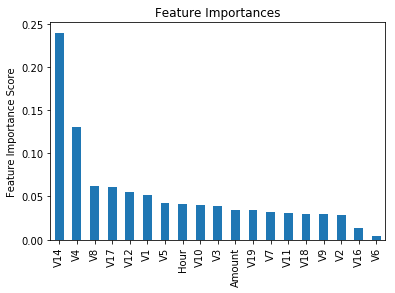

In [31]:

gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, X_train_smote, y_train_smote)

In [27]:
param_test1 = {'n_estimators':list(range(20,81,10))}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='average_precision',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=0)

In [28]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.99948, std: 0.00005, params: {'n_estimators': 20},
  mean: 0.99969, std: 0.00004, params: {'n_estimators': 30},
  mean: 0.99979, std: 0.00005, params: {'n_estimators': 40},
  mean: 0.99984, std: 0.00006, params: {'n_estimators': 50},
  mean: 0.99987, std: 0.00009, params: {'n_estimators': 60},
  mean: 0.99989, std: 0.00006, params: {'n_estimators': 70},
  mean: 0.99992, std: 0.00006, params: {'n_estimators': 80}],
 {'n_estimators': 80},
 0.9999180242112464)

In [15]:
param_test2 = {'max_depth':list(range(5,12,2)), 'min_samples_split':list(range(600,1601,200))}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='average_precision',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train_smote, y_train_smote)


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [5, 7, 9, 11], 'min_samples_split': [600, 800, 1000, 1200, 1400, 1600]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=0)

In [17]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.99944, std: 0.00016, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.99951, std: 0.00019, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.99949, std: 0.00020, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.99951, std: 0.00011, params: {'max_depth': 5, 'min_samples_split': 1200},
  mean: 0.99944, std: 0.00018, params: {'max_depth': 5, 'min_samples_split': 1400},
  mean: 0.99948, std: 0.00016, params: {'max_depth': 5, 'min_samples_split': 1600},
  mean: 0.99984, std: 0.00016, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.99983, std: 0.00009, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.99983, std: 0.00012, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.99981, std: 0.00010, params: {'max_depth': 7, 'min_samples_split': 1200},
  mean: 0.99984, std: 0.00008, params: {'max_depth': 7, 'min_samples_split': 1400},
  mean: 0.99982, std: 0.00009, params: {'max_depth': 7, 'min_samples_split': 160


Model Report
Recall : 1
Precision: 0.999563
Average Precision: 0.999563
CV Score : Mean - 0.9999562 | Std - 4.316926e-05 | Min - 0.9998738 | Max - 0.9999923


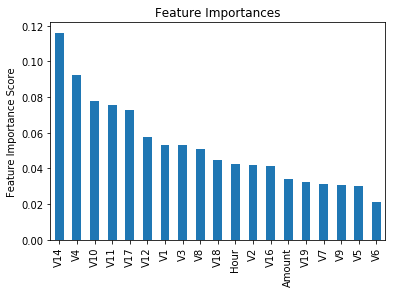

In [20]:
modelfit(gsearch2.best_estimator_, X_train_smote, y_train_smote)

In [22]:
param_test4 = {'max_features':[4, 6, 8, 10, 12, 14, 16]}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=11, min_samples_split=1400, min_samples_leaf=60, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='average_precision',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train_smote, y_train_smote)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_


([mean: 0.99996, std: 0.00003, params: {'max_features': 4},
  mean: 0.99996, std: 0.00003, params: {'max_features': 6},
  mean: 0.99996, std: 0.00002, params: {'max_features': 8},
  mean: 0.99995, std: 0.00005, params: {'max_features': 10},
  mean: 0.99996, std: 0.00004, params: {'max_features': 12},
  mean: 0.99992, std: 0.00006, params: {'max_features': 14},
  mean: 0.99995, std: 0.00004, params: {'max_features': 16}],
 {'max_features': 6},
 0.9999601950983671)


Model Report
Recall : 1
Precision: 0.999313
Average Precision: 0.999313
CV Score : Mean - 0.9999602 | Std - 3.354359e-05 | Min - 0.9998964 | Max - 0.9999943


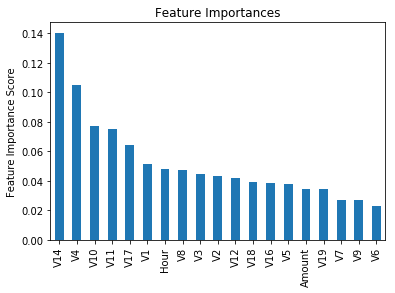

In [23]:
modelfit(gsearch4.best_estimator_, X_train_smote, y_train_smote)


Model Report
Recall : 0.9999
Precision: 0.998755
Average Precision: 0.998696
CV Score : Mean - 0.9996677 | Std - 0.000457955 | Min - 0.9987542 | Max - 0.9999339


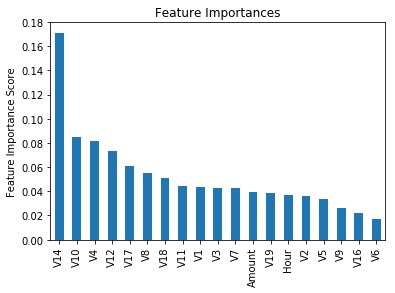

In [27]:
modelfit(gsearch4.best_estimator_, X_test_smote, y_test_smote.values.ravel())


Model Report
Recall : 0.5238
Precision: 0.587786
Average Precision: 0.308707
CV Score : Mean - 0.344936 | Std - 0.2127882 | Min - 0.05721374 | Max - 0.6716413


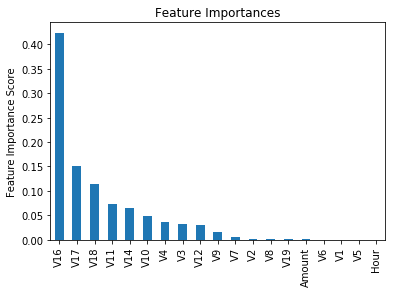

In [28]:
modelfit(gsearch4.best_estimator_, X_test, y_test.values.ravel())


Model Report
Recall : 0.585
Precision: 0.781818
Average Precision: 0.458104
CV Score : Mean - 0.3744447 | Std - 0.249144 | Min - 0.119376 | Max - 0.8365462


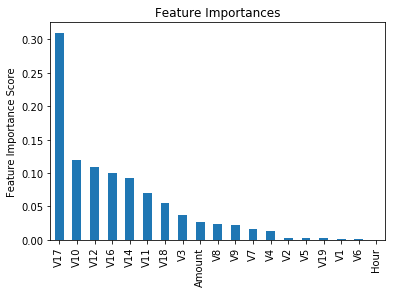

In [37]:
modelfit(gsearch2.best_estimator_, X_test, y_test.values.ravel())


Model Report
Recall : 0.8095
Precision: 0.875000
Average Precision: 0.708661
CV Score : Mean - 0.494077 | Std - 0.1894352 | Min - 0.1613297 | Max - 0.7322611


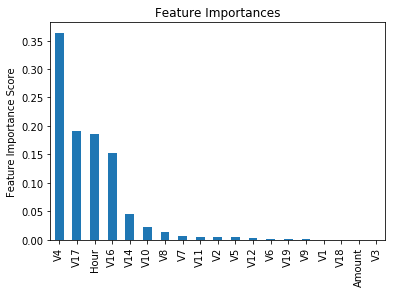

In [36]:
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, X_test, y_test.values.ravel())